In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Polygon
import os

from sentinelhub import FisRequest, BBox, Geometry, CRS, WcsRequest, CustomUrlParam, \
    DataCollection, HistogramType,SHConfig
from sentinelhub.time_utils import parse_time

In [2]:
%set_env SH_INSTANCE_ID=e9d989da-4f24-4011-b2e9-75037c492de4
sh_mundi_config = SHConfig()
sh_mundi_config.sh_base_url = 'https://shservices.mundiwebservices.com'
sh_mundi_config.instance_id = os.environ['SH_INSTANCE_ID']
if sh_mundi_config.instance_id == '':
    print("Warning! To use FIS functionality, please configure the `instance_id`.")

env: SH_INSTANCE_ID=e9d989da-4f24-4011-b2e9-75037c492de4


In [3]:
geo_json = 'POLYGON((2.182075 48.954682,2.099631 48.788478,2.24803 48.658021,2.368948 48.694293,2.451392 48.85358,2.423911 48.922207,2.182075 48.954682))'
import geojson
import shapely.wkt

area = shapely.wkt.loads(geo_json)
gj_feat = geojson.Feature(geometry=area, properties={})

import shapely.geometry
import IPython.display
IPython.display.GeoJSON(gj_feat)

<IPython.display.GeoJSON object>

In [4]:
def getPolygon(line):
    x = line.replace("POLYGON", "").replace("(","").replace(")", "")
    arr = x.split(",")
    createdArr = []
    
    for a in arr:
        temp = a.split(" ")
        tempTuple = (float(temp[0]), float(temp[1]))
        createdArr.append(tempTuple)
    
    return createdArr

In [5]:
polygon_shape=getPolygon(geo_json)

In [6]:
geo_shape = Geometry(Polygon(polygon_shape),
                     CRS.WGS84)
time_interval = ('2018-04-30T00:00:00Z', '2021-04-19T23:59:59Z')

In [7]:
if 'CUSTOM_COLLECTION' not in DataCollection.__members__:
    DataCollection.define(name='CUSTOM_COLLECTION')
    
fis_request = FisRequest(
    data_collection=DataCollection.CUSTOM_COLLECTION,
    layer='RAW_NO2_DATA',
    geometry_list=[geo_shape],
    time=time_interval,
    resolution='3500m',
    data_folder='./data',
    bins=20,
    histogram_type=HistogramType.EQUIDISTANT,
    config=sh_mundi_config
)

In [8]:
fis_data = fis_request.get_data(save_data=True)  # Takes about 30s, to avoid redownloading we are saving results
#fis_data
fis_data[0]['C0'][0]

{'date': '2021-04-19',
 'basicStats': {'min': 126.07571411132812,
  'max': 194.56549072265625,
  'mean': 162.6141324926306,
  'stDev': 17.879710758722773},
 'histogram': {'bins': [{'lowEdge': 126.07571411132812, 'count': 3.0},
   {'lowEdge': 129.50020294189454, 'count': 0.0},
   {'lowEdge': 132.92469177246093, 'count': 2.0},
   {'lowEdge': 136.34918060302735, 'count': 2.0},
   {'lowEdge': 139.77366943359374, 'count': 1.0},
   {'lowEdge': 143.19815826416016, 'count': 3.0},
   {'lowEdge': 146.62264709472657, 'count': 6.0},
   {'lowEdge': 150.04713592529296, 'count': 1.0},
   {'lowEdge': 153.47162475585938, 'count': 1.0},
   {'lowEdge': 156.89611358642577, 'count': 3.0},
   {'lowEdge': 160.3206024169922, 'count': 4.0},
   {'lowEdge': 163.7450912475586, 'count': 3.0},
   {'lowEdge': 167.169580078125, 'count': 6.0},
   {'lowEdge': 170.5940689086914, 'count': 4.0},
   {'lowEdge': 174.0185577392578, 'count': 4.0},
   {'lowEdge': 177.44304656982422, 'count': 1.0},
   {'lowEdge': 180.8675354003

In [9]:
def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    """
    COLUMNS = ['channel', 'date', 'min', 'max', 'mean', 'stDev']
    data = []

    for fis_response in fis_data:
        for channel, channel_stats in fis_response.items():
            for stat in channel_stats:
                row = [int(channel[1:]), parse_time(stat['date'], force_datetime=True)]

                for column in COLUMNS[2:]:
                    row.append(stat['basicStats'][column])

                data.append(row)

    return pd.DataFrame(data, columns=COLUMNS).sort_values(['channel', 'date'])


df = fis_data_to_dataframe(fis_data)

df.head()

,channel,date,min,max,mean,stDev
155,0,2018-04-30,70.763367,1.152716e+02,9.761505e+01,1.269343e+01
154,0,2018-05-07,66.772209,1.176932e+02,9.467931e+01,1.410857e+01
153,0,2018-05-14,61.784447,1.307558e+02,9.393186e+01,1.769051e+01
152,0,2018-05-21,39.540070,8.628657e+01,6.419955e+01,1.094125e+01
151,0,2018-05-28,46.569546,9.969210e+36,1.846150e+35,1.344017e+36


In [10]:
df.describe()

,channel,min,max,mean,stDev
count,156.0,156.000000,1.560000e+02,1.560000e+02,1.560000e+02
mean,0.0,61.695988,7.668623e+35,1.349110e+35,1.922462e+35
std,0.0,31.854975,2.665044e+36,8.565628e+35,7.512773e+35
min,0.0,-10.067692,6.394333e+01,2.985497e+01,3.466272e+00
25%,0.0,39.536970,1.135644e+02,7.759966e+01,1.520831e+01
50%,0.0,57.129463,1.495663e+02,1.019206e+02,2.109295e+01
75%,0.0,74.130964,2.040732e+02,1.438330e+02,3.037025e+01
max,0.0,166.182449,9.969210e+36,9.599980e+36,4.760777e+36


In [11]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [12]:
for col in df.columns:
    if col!='channel' and col!='date':
        df=remove_outlier(df,col)
df.describe()

,channel,min,max,mean,stDev
count,130.0,130.000000,130.000000,130.000000,130.000000
mean,0.0,61.167087,140.055672,97.176125,20.286479
std,0.0,26.067676,46.052206,34.544994,8.208292
min,0.0,14.299153,63.943325,29.854973,3.466272
25%,0.0,40.892836,105.460571,73.037796,14.453033
50%,0.0,58.426752,130.946358,94.078211,18.573248
75%,0.0,73.801289,165.550842,117.617039,24.439956
max,0.0,121.946060,271.231750,187.625066,44.938517


In [13]:
import plotly.graph_objects as go
py.offline.init_notebook_mode(connected=True)

import pandas as pd

fig = go.Figure()

fig.add_trace(go.Scatter(x=df['date'], y=df['min'],
                    mode='lines',
                    name='min'))
fig.add_trace(go.Scatter(x=df['date'], y=df['max'],
                    mode='lines',
                    name='max'))
fig.add_trace(go.Scatter(x=df['date'], y=df['mean'],
                    mode='lines',
                    name='mean'))
fig.add_trace(go.Scatter(x=df['date'], y=df['stDev'],
                    mode='lines',
                    name='stDev'))

fig.update_layout(
    title = 'Time Series Analysis for NO2',
    xaxis_tickformat = '%d %B (%a)<br>%Y'
)

py.offline.iplot(fig)

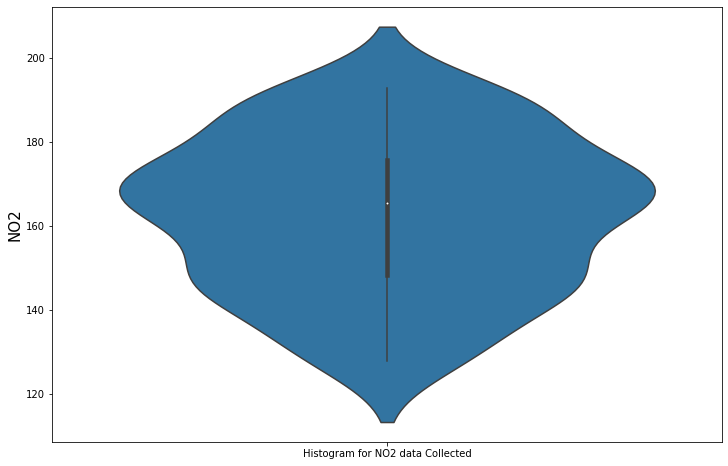

In [14]:
plot_data = []
for idx, fis_response in enumerate(fis_data):
    bins = fis_response['C0'][0]['histogram']['bins']

    counts = [value['count'] for value in bins]
    total_counts = sum(counts)
    counts = [round(100 * count / total_counts) for count in counts]

    bin_size = bins[1]['lowEdge'] - bins[0]['lowEdge']
    splits = [value['lowEdge'] + bin_size / 2 for value in bins]

    data = []
    for count, split in zip(counts, splits):
        data.extend([split] * count)
    plot_data.append(np.array(data))


fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.violinplot(data=plot_data, ax=ax)
ax.set(xticklabels=['Histogram for NO2 data Collected'])
plt.ylabel('NO2', fontsize=15);